In [55]:
import json
import pathlib
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True

FILES = [
    "out/config_Zendure2400_noBattery.json",
    "out/config_Zendure2400_2880kwh.json",
    "out/config_Zendure2400_5760kwh.json",
    "out/config_Zendure2400_8640kwh.json",
    "out/config_Zendure2400_11520kwh.json",
    "out/config_Zendure2400_14400kwh.json",
]

def load_json(path):
    with open(path, "r") as f:
        return json.load(f)
    
def battery_size_from_config(data) -> int:
    # total capacity across phases (Wh)
    return sum(data["configuration"]["battery"]["capacity_Wh_per_phase"])

Extract monthly data (cumulated phases)

In [56]:
MONTH_ROWS = []

for file in FILES:
    scenario = pathlib.Path(file).stem.replace("config_", "")
    data = load_json(file)

    battery_size_wh = battery_size_from_config(data)

    months = data.get("months", [])
    if not months:
        print(f"⚠️ No months section in {scenario}, skipping")
        continue

    for m in months:
        month_range = m.get("range", {})

        is_full_month = month_range.get("is_full_month", False)
        n_days = month_range.get("calendar_duration_days", 0)

        # 🚫 skip incomplete / short months
        if not is_full_month and n_days < 28:
            continue

        month_id = m["range_id"]
        results = m["results"]

        # ---- cumulate energy across phases ----
        energy = results.get("energy", {})
        injected = energy.get("injected", [])
        consumed = energy.get("consumed", [])

        injected_kwh = sum(abs(e["energy_kwh"]) for e in injected)
        consumed_kwh = sum(abs(e["energy_kwh"]) for e in consumed)

        injected_chf = sum(e["delta_chf"] for e in injected)
        consumed_chf = sum(e["delta_chf"] for e in consumed)

        rentability = results.get("rentability", {})

        MONTH_ROWS.append({
            "month": month_id,
            "scenario": scenario,
            "battery_size_wh": battery_size_wh,

            "gain_chf": rentability.get("total_gain_chf", 0.0),

            "grid_consumed_kwh": consumed_kwh,
            "grid_injected_kwh": injected_kwh,

            "grid_consumed_chf": consumed_chf,
            "grid_injected_chf": injected_chf,
        })

df_monthly = pd.DataFrame(MONTH_ROWS)

df_monthly["month"] = pd.to_datetime(df_monthly["month"])
df_monthly = df_monthly.sort_values(["battery_size_wh", "month"])

scenario_order = (
    df_monthly[["scenario", "battery_size_wh"]]
    .drop_duplicates()
    .sort_values("battery_size_wh")["scenario"]
    .tolist()
)


Monthly gain (CHF) graph

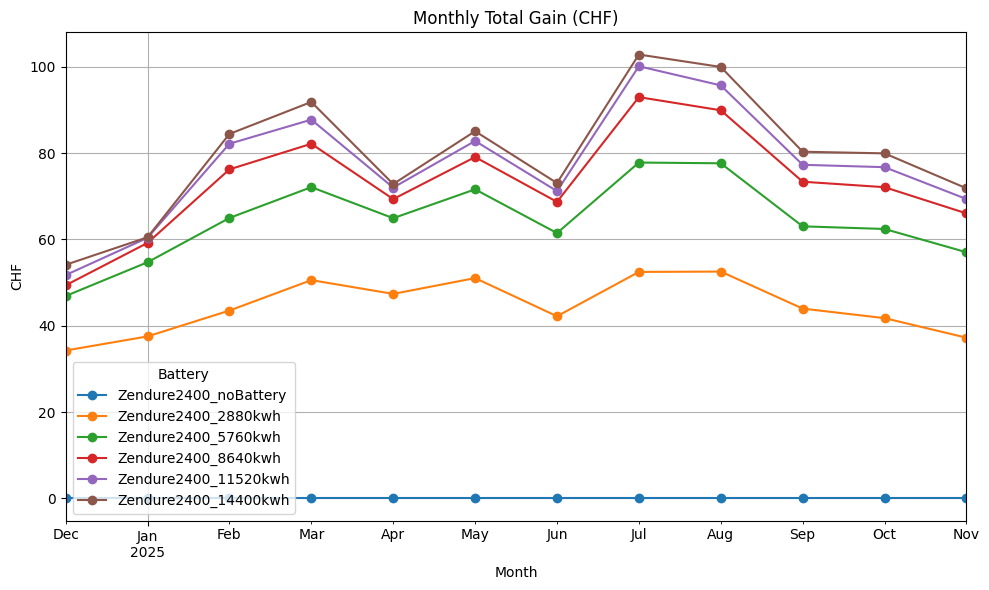

In [57]:
pivot_gain = df_monthly.pivot(
    index="month",
    columns="scenario",
    values="gain_chf"
)

pivot_gain = pivot_gain[scenario_order]

pivot_gain.plot(marker="o")
plt.title("Monthly Total Gain (CHF)")
plt.xlabel("Month")
plt.ylabel("CHF")
plt.legend(title="Battery")
plt.tight_layout()
plt.show()


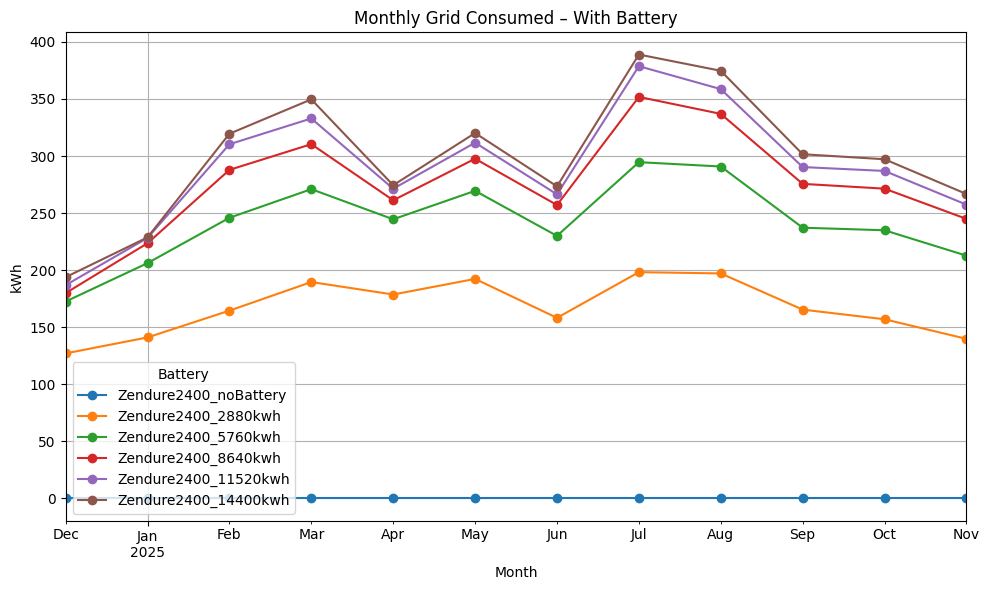

In [58]:
pivot_consumed = df_monthly.pivot(
    index="month",
    columns="scenario",
    values="grid_consumed_kwh"
)

pivot_consumed = pivot_consumed[scenario_order]

pivot_consumed.plot(marker="o")
plt.title("Monthly Grid Consumed – With Battery")
plt.xlabel("Month")
plt.ylabel("kWh")
plt.legend(title="Battery")
plt.tight_layout()
plt.show()


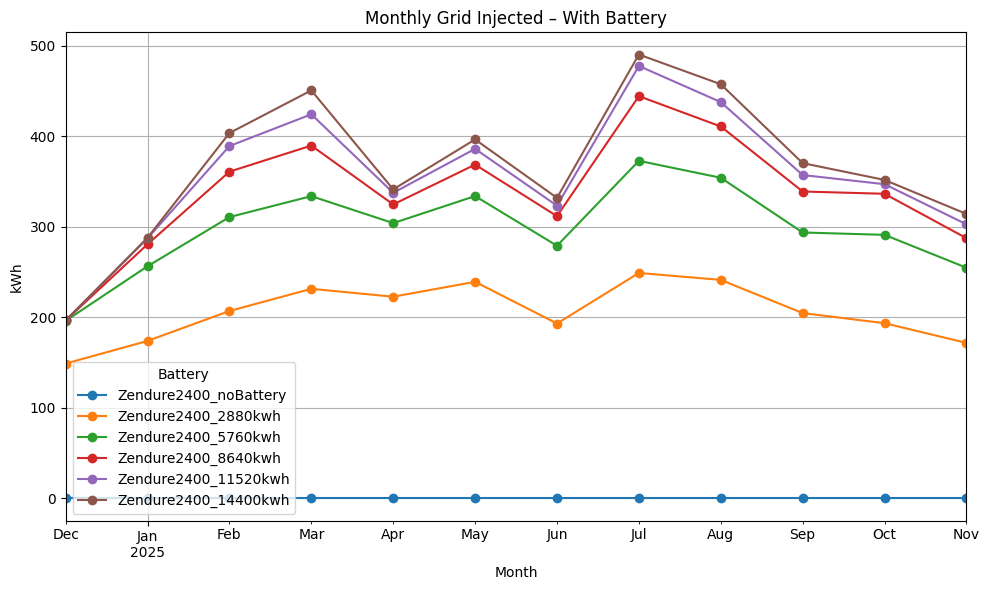

In [59]:
pivot_injected = df_monthly.pivot(
    index="month",
    columns="scenario",
    values="grid_injected_kwh"
)

pivot_injected = pivot_injected[scenario_order]

pivot_injected.plot(marker="o")
plt.title("Monthly Grid Injected – With Battery")
plt.xlabel("Month")
plt.ylabel("kWh")
plt.legend(title="Battery")
plt.tight_layout()
plt.show()


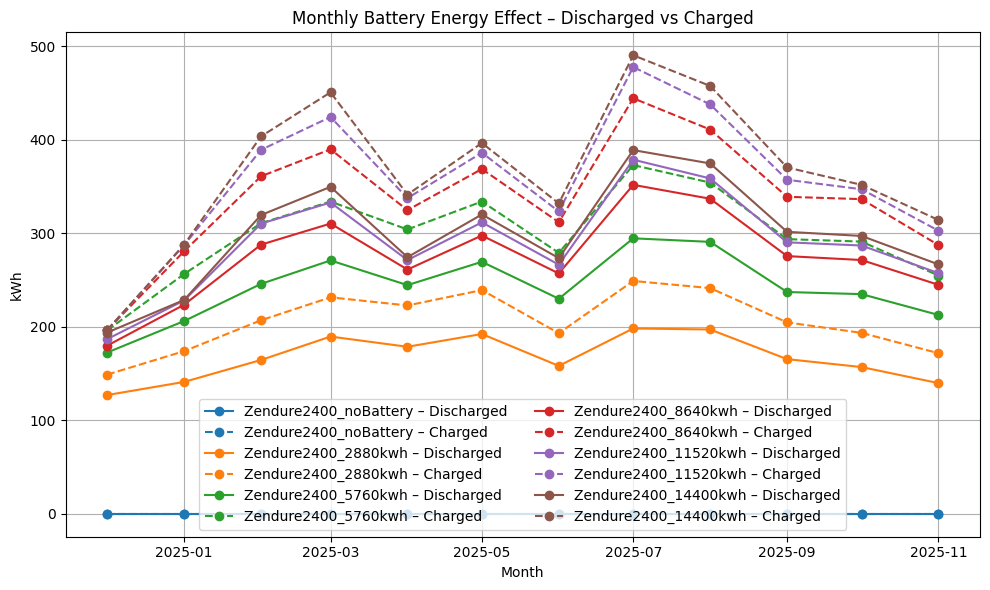

In [60]:
plt.figure(figsize=(10, 6))

color_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for i, scenario in enumerate(scenario_order):
    subset = (
        df_monthly[df_monthly["scenario"] == scenario]
        .sort_values("month")
    )

    color = color_cycle[i % len(color_cycle)]

    # Discharged effect (grid consumption reduction) – solid
    plt.plot(
        subset["month"],
        subset["grid_consumed_kwh"],
        marker="o",
        linestyle="-",
        color=color,
        label=f"{scenario} – Discharged"
    )

    # Charged effect (grid injection increase) – dashed
    plt.plot(
        subset["month"],
        subset["grid_injected_kwh"],
        marker="o",
        linestyle="--",
        color=color,
        label=f"{scenario} – Charged"
    )

plt.title("Monthly Battery Energy Effect – Discharged vs Charged")
plt.xlabel("Month")
plt.ylabel("kWh")
plt.legend(ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


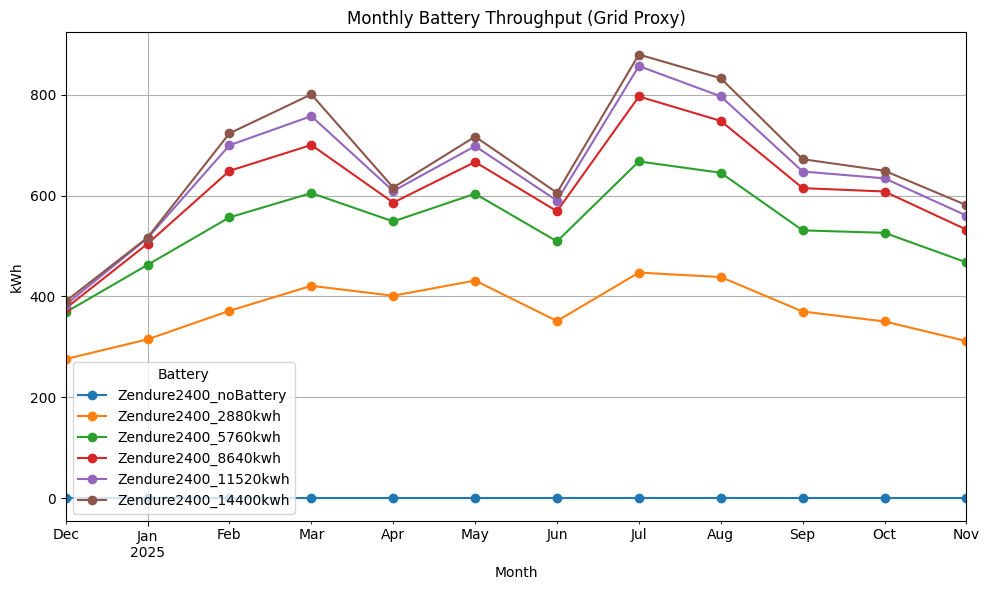

In [61]:
df_monthly["battery_throughput_kwh"] = (
    df_monthly["grid_consumed_kwh"] +
    df_monthly["grid_injected_kwh"]
)

pivot = df_monthly.pivot(
    index="month",
    columns="scenario",
    values="battery_throughput_kwh"
)

pivot = pivot[scenario_order]

pivot.plot(marker="o")
plt.title("Monthly Battery Throughput (Grid Proxy)")
plt.xlabel("Month")
plt.ylabel("kWh")
plt.legend(title="Battery")
plt.grid(True)
plt.tight_layout()
plt.show()


In [62]:
FULL_ROWS = []

for file in FILES:
    scenario = pathlib.Path(file).stem.replace("config_", "")
    data = load_json(file)

    months = data.get("months", [])
    if not months:
        continue

    for m in months:
        month_range = m.get("range", {})

        is_full_month = month_range.get("is_full_month", False)
        n_days = month_range.get("calendar_duration_days", 0)

        if not is_full_month and n_days < 28:
            continue

        month_id = m["range_id"]
        status = m["results"].get("battery", {}).get("status", {})

        full_samples = 0
        total_samples = status.get("samples_analyzed", 0)

        if total_samples == 0:
            continue

        for phase in ["A", "B", "C"]:
            full_samples += (
                status.get(phase, {})
                .get("full", {})
                .get("sample_count", 0)
            )

        FULL_ROWS.append({
            "month": month_id,
            "scenario": scenario,
            "avg_full_pct": 100.0 * full_samples / total_samples
        })

df_monthly_full = pd.DataFrame(FULL_ROWS)
df_monthly_full["month"] = pd.to_datetime(df_monthly_full["month"])


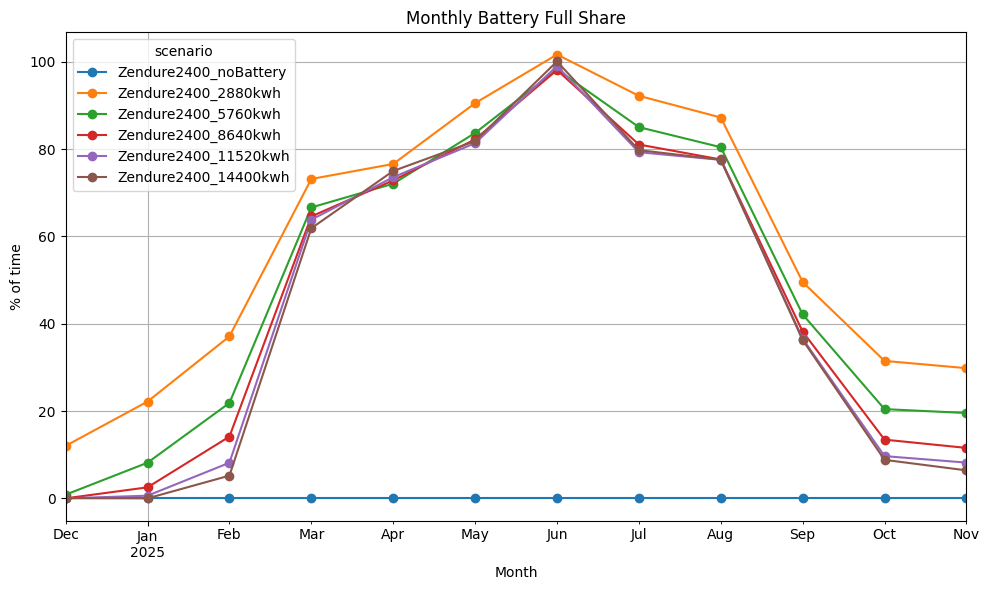

In [63]:
pivot = df_monthly_full.pivot(
    index="month",
    columns="scenario",
    values="avg_full_pct"
)

pivot = pivot[scenario_order]

pivot.plot(marker="o")
plt.title("Monthly Battery Full Share")
plt.xlabel("Month")
plt.ylabel("% of time")
plt.grid(True)
plt.tight_layout()
plt.show()


In [64]:
EMPTY_ROWS = []

for file in FILES:
    scenario = pathlib.Path(file).stem.replace("config_", "")
    data = load_json(file)

    months = data.get("months", [])
    if not months:
        continue

    for m in months:
        month_range = m.get("range", {})

        is_full_month = month_range.get("is_full_month", False)
        n_days = month_range.get("calendar_duration_days", 0)

        if not is_full_month and n_days < 28:
            continue

        month_id = m["range_id"]
        status = m["results"].get("battery", {}).get("status", {})

        total_samples = status.get("samples_analyzed", 0)
        if total_samples == 0:
            continue

        empty_samples = 0
        for phase in ["A", "B", "C"]:
            empty_samples += (
                status.get(phase, {})
                .get("empty", {})
                .get("sample_count", 0)
            )

        EMPTY_ROWS.append({
            "month": month_id,
            "scenario": scenario,
            "avg_empty_pct": 100.0 * empty_samples / total_samples
        })

df_monthly_empty = pd.DataFrame(EMPTY_ROWS)
df_monthly_empty["month"] = pd.to_datetime(df_monthly_empty["month"])


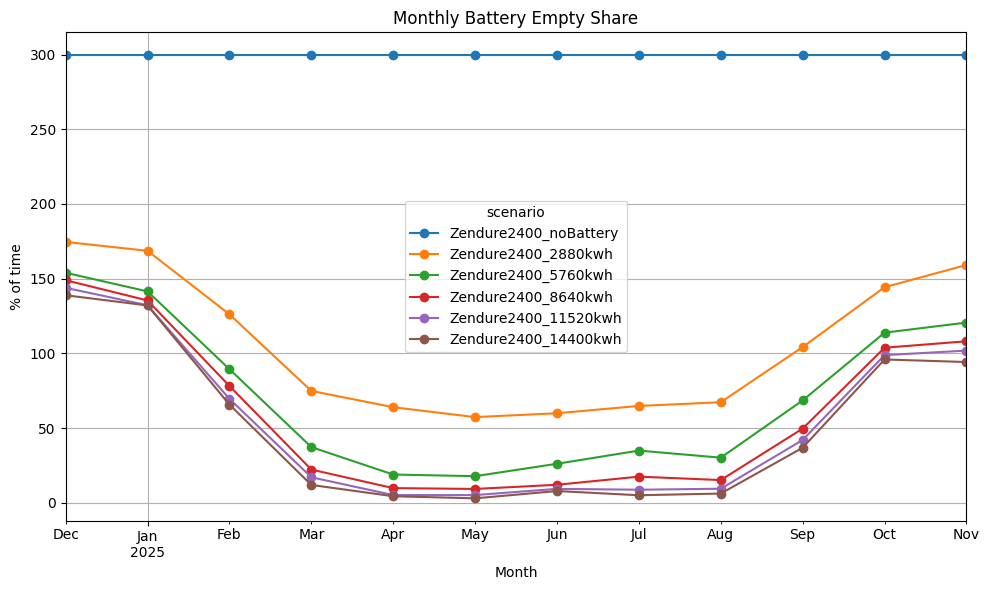

In [65]:
pivot = df_monthly_empty.pivot(
    index="month",
    columns="scenario",
    values="avg_empty_pct"
)

pivot = pivot[scenario_order]

pivot.plot(marker="o")
plt.title("Monthly Battery Empty Share")
plt.xlabel("Month")
plt.ylabel("% of time")
plt.grid(True)
plt.tight_layout()
plt.show()


In [66]:
UNDERSIZE_ROWS = []

for file in FILES:
    scenario = pathlib.Path(file).stem.replace("config_", "")
    data = load_json(file)

    months = data.get("months", [])
    if not months:
        continue

    for m in months:
        month_range = m.get("range", {})

        is_full_month = month_range.get("is_full_month", False)
        n_days = month_range.get("calendar_duration_days", 0)

        # same filtering rule
        if not is_full_month and n_days < 28:
            continue

        month_id = m["range_id"]
        undersize = m["results"].get("battery_energy_undersize_days", {})

        UNDERSIZE_ROWS.append({
            "month": month_id,
            "scenario": scenario,
            "energy_undersize_pct": undersize.get("percent", 0.0)
        })

df_monthly_undersize = pd.DataFrame(UNDERSIZE_ROWS)
df_monthly_undersize["month"] = pd.to_datetime(df_monthly_undersize["month"])


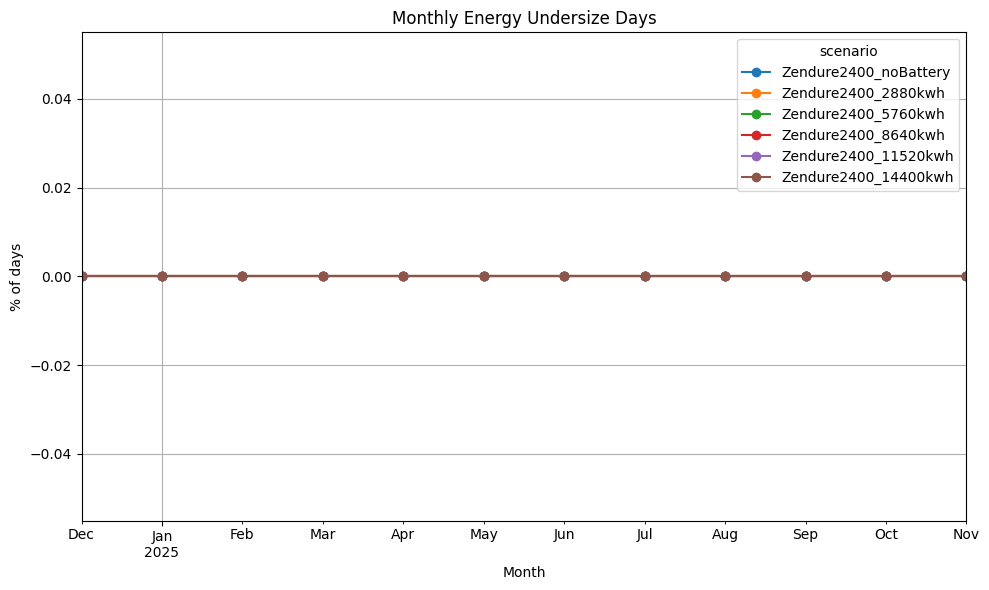

In [67]:
pivot = df_monthly_undersize.pivot(
    index="month",
    columns="scenario",
    values="energy_undersize_pct"
)

pivot = pivot[scenario_order]

pivot.plot(marker="o")
plt.title("Monthly Energy Undersize Days")
plt.xlabel("Month")
plt.ylabel("% of days")
plt.grid(True)
plt.tight_layout()
plt.show()


In [81]:
POWER_ROWS = []

for file in FILES:
    scenario = pathlib.Path(file).stem.replace("config_", "")
    data = load_json(file)

    months = data.get("months", [])
    if not months:
        continue

    for m in months:
        r = m.get("range", {})
        if not r.get("is_full_month", False) and r.get("calendar_duration_days", 0) < 28:
            continue

        pu = m["results"].get("battery", {}).get("power_usage", {})
        total_samples = pu.get("samples_analyzed", 0)
        if total_samples == 0:
            continue

        at_max_samples = (
            # charging @ max
            sum(
                pu.get("charging", {})
                  .get(p, {})
                  .get("at_max", {})
                  .get("sample_count", 0)
                for p in ["A", "B", "C"]
            )
            +
            # discharging @ max
            sum(
                pu.get("discharging", {})
                  .get(p, {})
                  .get("at_max", {})
                  .get("sample_count", 0)
                for p in ["A", "B", "C"]
            )
            +
            # idle – could charge @ max
            sum(
                pu.get("idle", {})
                  .get(p, {})
                  .get("could_charge_at_max", {})
                  .get("sample_count", 0)
                for p in ["A", "B", "C"]
            )
            +
            # idle – could discharge @ max
            sum(
                pu.get("idle", {})
                  .get(p, {})
                  .get("could_discharge_at_max", {})
                  .get("sample_count", 0)
                for p in ["A", "B", "C"]
            )
        )

        POWER_ROWS.append({
            "month": m["range_id"],
            "scenario": scenario,
            "power_at_max_pct": 100.0 * at_max_samples / total_samples
        })

df_monthly_power_sat = pd.DataFrame(POWER_ROWS)
df_monthly_power_sat["month"] = pd.to_datetime(df_monthly_power_sat["month"])


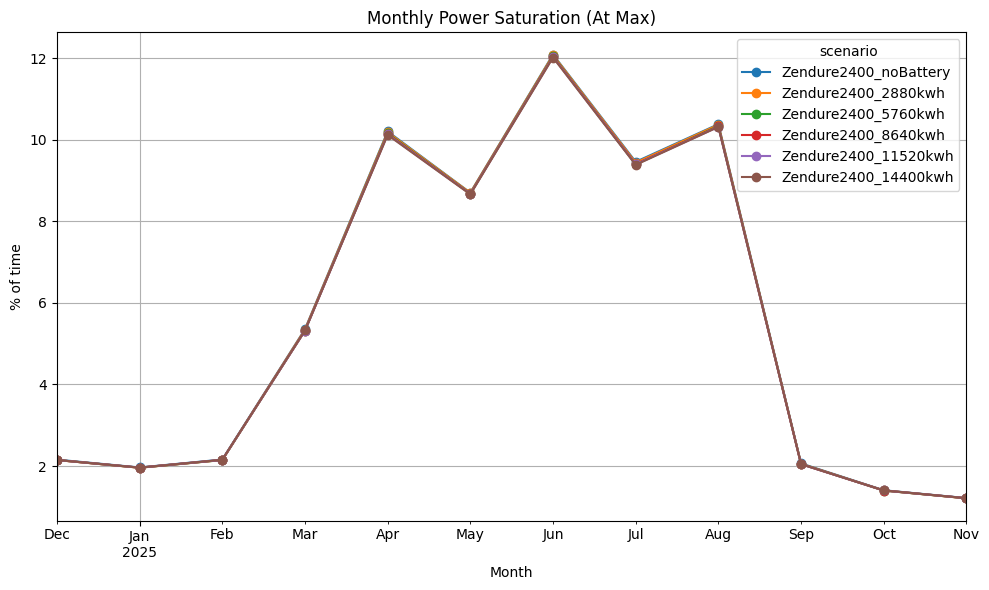

In [82]:
pivot = df_monthly_power_sat.pivot(
    index="month",
    columns="scenario",
    values="power_at_max_pct"
)

pivot = pivot[scenario_order]

pivot.plot(marker="o")
plt.title("Monthly Power Saturation (At Max)")
plt.xlabel("Month")
plt.ylabel("% of time")
plt.grid(True)
plt.tight_layout()
plt.show()


In [79]:
ACTIVE_POWER_ROWS = []

for file in FILES:
    scenario = pathlib.Path(file).stem.replace("config_", "")
    data = load_json(file)

    months = data.get("months", [])
    if not months:
        continue

    for m in months:
        r = m.get("range", {})
        if not r.get("is_full_month", False) and r.get("calendar_duration_days", 0) < 28:
            continue

        pu = m["results"].get("battery", {}).get("power_usage", {})
        total_samples = pu.get("samples_analyzed", 0)
        if total_samples == 0:
            continue

        active_at_max_samples = (
            sum(
                pu.get("charging", {})
                  .get(p, {})
                  .get("at_max", {})
                  .get("sample_count", 0)
                for p in ["A", "B", "C"]
            )
            +
            sum(
                pu.get("discharging", {})
                  .get(p, {})
                  .get("at_max", {})
                  .get("sample_count", 0)
                for p in ["A", "B", "C"]
            )
        )

        ACTIVE_POWER_ROWS.append({
            "month": m["range_id"],
            "scenario": scenario,
            "active_power_at_max_pct": 100.0 * active_at_max_samples / total_samples
        })

df_monthly_active_power_sat = pd.DataFrame(ACTIVE_POWER_ROWS)
df_monthly_active_power_sat["month"] = pd.to_datetime(df_monthly_active_power_sat["month"])


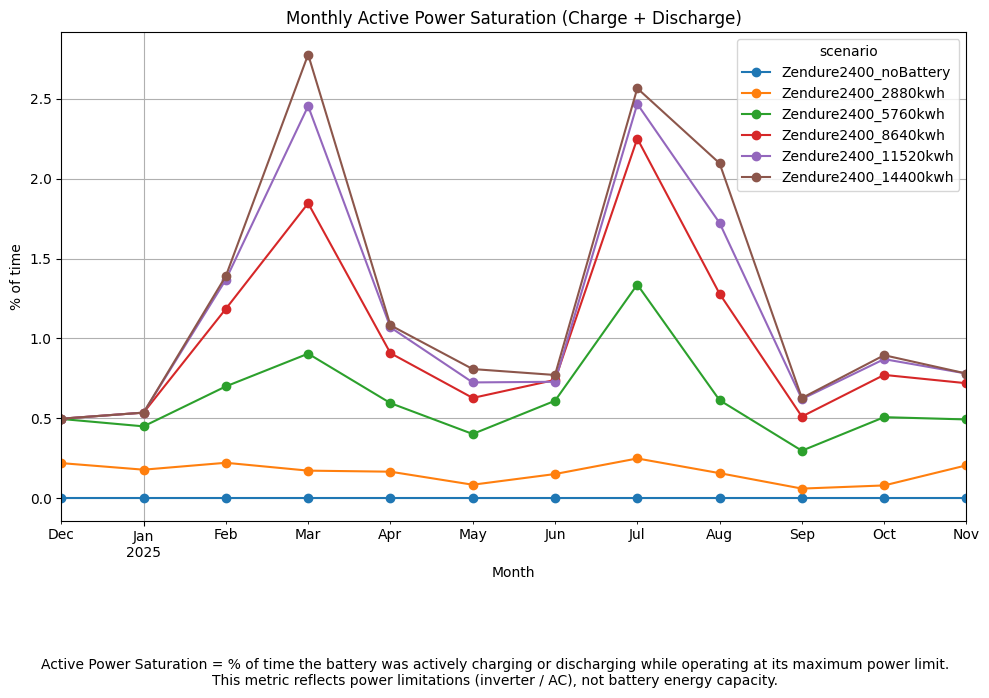

In [92]:
pivot = df_monthly_active_power_sat.pivot(
    index="month",
    columns="scenario",
    values="active_power_at_max_pct"
)

pivot = pivot[scenario_order]

pivot.plot(marker="o")
plt.title("Monthly Active Power Saturation (Charge + Discharge)")
plt.xlabel("Month")
plt.ylabel("% of time")
plt.grid(True)
plt.tight_layout()
plt.figtext(
    0.5, -0.15,
    "Active Power Saturation = % of time the battery was actively charging or discharging "
    "while operating at its maximum power limit.\n"
    "This metric reflects power limitations (inverter / AC), not battery energy capacity.",
    ha="center",
    fontsize=10
)
plt.show()


In [83]:
IDLE_POWER_ROWS = []

for file in FILES:
    scenario = pathlib.Path(file).stem.replace("config_", "")
    data = load_json(file)

    months = data.get("months", [])
    if not months:
        continue

    for m in months:
        r = m.get("range", {})
        if not r.get("is_full_month", False) and r.get("calendar_duration_days", 0) < 28:
            continue

        pu = m["results"].get("battery", {}).get("power_usage", {})
        total_samples = pu.get("samples_analyzed", 0)
        if total_samples == 0:
            continue

        idle_power_limited_samples = (
            sum(
                pu.get("idle", {})
                  .get(p, {})
                  .get("could_charge_at_max", {})
                  .get("sample_count", 0)
                for p in ["A", "B", "C"]
            )
            +
            sum(
                pu.get("idle", {})
                  .get(p, {})
                  .get("could_discharge_at_max", {})
                  .get("sample_count", 0)
                for p in ["A", "B", "C"]
            )
        )

        IDLE_POWER_ROWS.append({
            "month": m["range_id"],
            "scenario": scenario,
            "idle_power_limited_pct": 100.0 * idle_power_limited_samples / total_samples
        })

df_monthly_idle_power_limited = pd.DataFrame(IDLE_POWER_ROWS)
df_monthly_idle_power_limited["month"] = pd.to_datetime(df_monthly_idle_power_limited["month"])


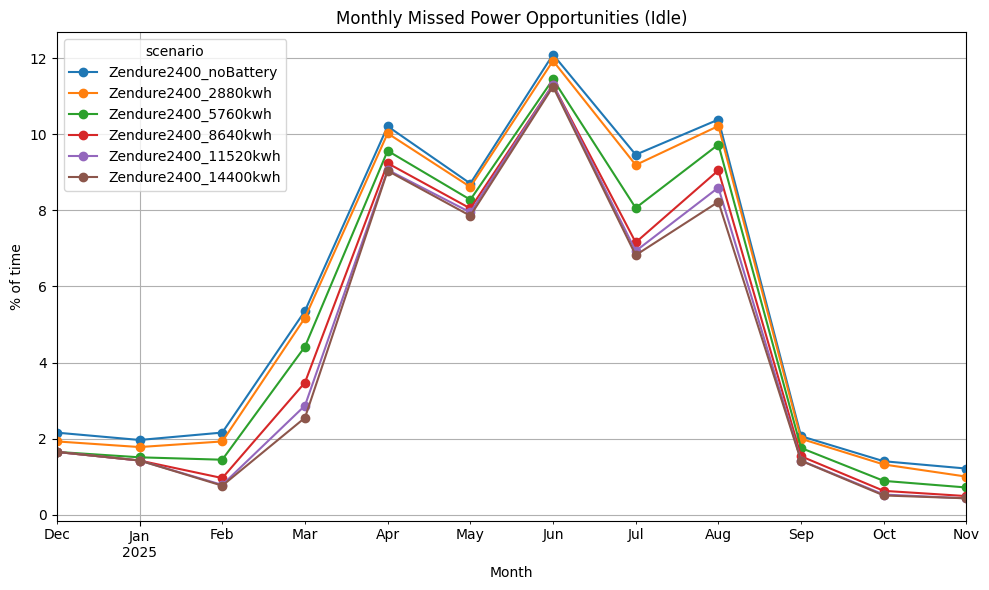

In [89]:
pivot = df_monthly_idle_power_limited.pivot(
    index="month",
    columns="scenario",
    values="idle_power_limited_pct"
)

pivot = pivot[scenario_order]

pivot.plot(marker="o")
plt.title("Monthly Missed Power Opportunities (Idle)")
plt.xlabel("Month")
plt.ylabel("% of time")
plt.grid(True)
plt.tight_layout()
plt.show()


In [77]:
POWER_STACK_ROWS = []

for file in FILES:
    scenario = pathlib.Path(file).stem.replace("config_", "")
    data = load_json(file)

    months = data.get("months", [])
    if not months:
        continue

    for m in months:
        r = m.get("range", {})
        if not r.get("is_full_month", False) and r.get("calendar_duration_days", 0) < 28:
            continue

        pu = m["results"].get("battery", {}).get("power_usage", {})
        total_samples = pu.get("samples_analyzed", 0)
        if total_samples == 0:
            continue

        def sum_samples(mode, phase_key):
            return sum(
                pu.get(mode, {})
                .get(p, {})
                .get(phase_key, {})
                .get("sample_count", 0)
                for p in ["A", "B", "C"]
            )

        POWER_STACK_ROWS.append({
            "month": m["range_id"],
            "scenario": scenario,

            "charging_at_max_pct": 100 * sum_samples("charging", "at_max") / total_samples,
            "charging_not_at_max_pct": 100 * sum_samples("charging", "not_at_max") / total_samples,

            "discharging_at_max_pct": 100 * sum_samples("discharging", "at_max") / total_samples,
            "discharging_not_at_max_pct": 100 * sum_samples("discharging", "not_at_max") / total_samples,

            "idle_could_charge_at_max_pct": 100 * sum_samples("idle", "could_charge_at_max") / total_samples,
            "idle_could_charge_not_at_max_pct": 100 * sum_samples("idle", "could_charge_not_at_max") / total_samples,

            "idle_could_discharge_at_max_pct": 100 * sum_samples("idle", "could_discharge_at_max") / total_samples,
            "idle_could_discharge_not_at_max_pct": 100 * sum_samples("idle", "could_discharge_not_at_max") / total_samples,

        })

df_monthly_power_stack = pd.DataFrame(POWER_STACK_ROWS)
df_monthly_power_stack["month"] = pd.to_datetime(df_monthly_power_stack["month"])


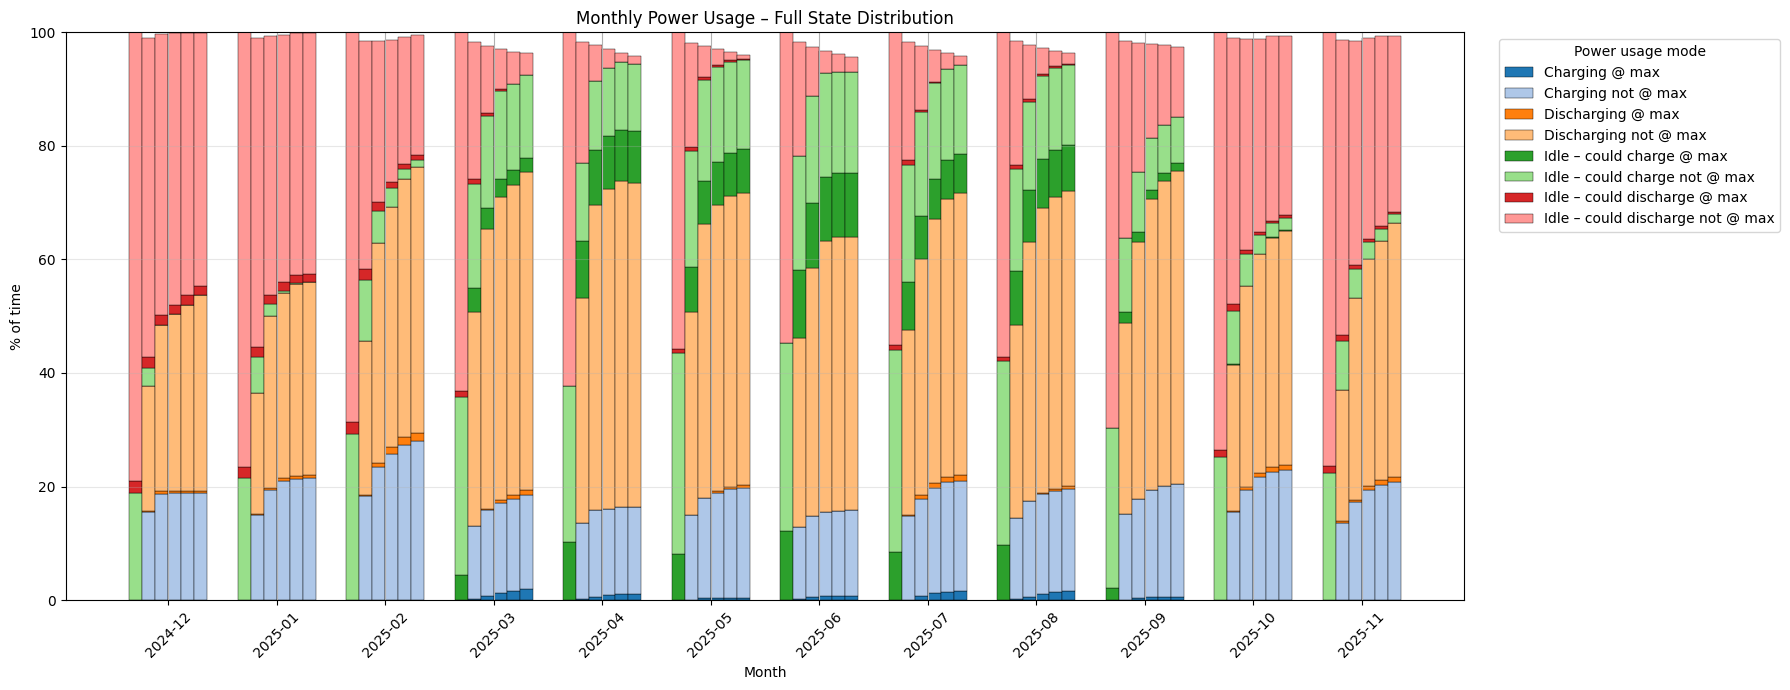

In [86]:
STACK_COMPONENTS = [
    # Charging
    ("charging_at_max_pct", "Charging @ max", "#1f77b4"),
    ("charging_not_at_max_pct", "Charging not @ max", "#aec7e8"),

    # Discharging
    ("discharging_at_max_pct", "Discharging @ max", "#ff7f0e"),
    ("discharging_not_at_max_pct", "Discharging not @ max", "#ffbb78"),

    # Idle – could charge
    ("idle_could_charge_at_max_pct", "Idle – could charge @ max", "#2ca02c"),
    ("idle_could_charge_not_at_max_pct", "Idle – could charge not @ max", "#98df8a"),

    # Idle – could discharge
    ("idle_could_discharge_at_max_pct", "Idle – could discharge @ max", "#d62728"),
    ("idle_could_discharge_not_at_max_pct", "Idle – could discharge not @ max", "#ff9896"),
]

months = sorted(df_monthly_power_stack["month"].unique())
x = np.arange(len(months))
bar_width = 0.12

plt.figure(figsize=(18, 7))

for b_idx, scenario in enumerate(scenario_order):
    subset = (
        df_monthly_power_stack[df_monthly_power_stack["scenario"] == scenario]
        .set_index("month")
        .reindex(months)
    )

    bottom = np.zeros(len(months))
    x_pos = x + b_idx * bar_width

    for col, label, color in STACK_COMPONENTS:
        if col not in subset:
            continue

        values = subset[col].values
        plt.bar(
            x_pos,
            values,
            width=bar_width,
            bottom=bottom,
            color=color,
            edgecolor="black",
            linewidth=0.3,
            label=label if b_idx == 0 else None
        )
        bottom += values

plt.xticks(
    x + bar_width * (len(scenario_order) - 1) / 2,
    [m.strftime("%Y-%m") for m in months],
    rotation=45
)

plt.xlabel("Month")
plt.ylabel("% of time")
plt.ylim(0, 100) 
plt.title("Monthly Power Usage – Full State Distribution")

plt.legend(
    title="Power usage mode",
    bbox_to_anchor=(1.02, 1),
    loc="upper left"
)

plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()
